# Analyse exploratoire

**Problématique de la ville de Seattle**  
Des relevés minutieux ont été effectués par vos agents en 2015 et en 2016. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments pour lesquels elles n’ont pas encore été mesurées.

Votre prédiction se basera sur les données déclaratives du permis d'exploitation commerciale (taille et usage des bâtiments, mention de travaux récents, date de construction..)

Vous cherchez également à évaluer l’intérêt de l’"ENERGY STAR Score" pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe.

**Votre mission**  
Vous sortez tout juste d’une réunion de brief avec votre équipe. Voici un récapitulatif de votre mission :

- Réaliser une courte analyse exploratoire.
- Tester différents modèles de prédiction afin de répondre au mieux à la problématique.

L’objectif est de se passer des relevés de consommation annuels (attention à la fuite de données), mais rien n'interdit d’en déduire des variables plus simples (nature et proportions des sources d’énergie utilisées). 

Faire bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).

Mettre en place une évaluation rigoureuse des performances de la régression, et optimiser les hyperparamètres et le choix d’algorithme de ML à l’aide d’une validation croisée.

**Livrables attendus**  
- Un notebook de l'analyse exploratoire mis au propre et annoté.
- Le code (ou un notebook) des différents tests de modèles mis au propre, dans lequel vous identifierez clairement le modèle final choisi.
- Un support de présentation pour la soutenance.

**Compétences évaluées**  
- Mettre en place le modèle d'apprentissage supervisé adapté au problème métier
- Évaluer les performances d’un modèle d'apprentissage supervisé
- Adapter les hyperparamètres d'un algorithme d'apprentissage supervisé afin de l'améliorer
- Transformer les variables pertinentes d'un modèle d'apprentissage supervisé

# Sommaire

__[I. Chargement et nettoyage des données](#I.-Chargement-et-nettoyage-des-données)__

__[II. Analyse exploratoire](#II.-Analyse-exploratoire)__\
[II.1 Variables qualitatives et variables quantitatives](#II.1-Variables-qualitatives-et-variables-quantitatives)\
[II.2 Variables quantitatives](#II.2-Variables-quantitatives)\
[II.2.1 Distribution des variables quantitatives](#II.2.1-Distribution-des-variables-quantitatives)\
[II.2.2 outliers](#II.2.2-outliers)\
[II.2.3 feature engineering](#II.2.3-feature-engineering)\
[II.2.4 Etude des corrélations](#II.2.4-Etude-des-corrélations)\
[II.2.4.i Variables cibles](#II.2.4.i-Variables-cibles)\
[II.2.4.ii Prédicteurs](#II.2.4.ii-Prédicteurs)\
[II.3 Variables catégorielles](#II.3-Variables-catégorielles)\
[II.3.1 Nettoyage des variables catégorielles](#II.3.1-Nettoyage-des-variables-catégorielles)\
[II.3.2 Etude des corrélations](#II.3.2-Etude-des-corrélations)

__[A suivre: Latitude, Longitude](#A-suivre:-Latitude,-Longitude)__

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno

# I. Chargement et nettoyage des données

In [37]:
# Chargement des deux datasets
data2015 = pd.read_csv("./data/2015-building-energy-benchmarking.csv")
data2016 = pd.read_csv("./data/2016-building-energy-benchmarking.csv")

On souhaiter fusionner les deux tables, mais l'indicateur Location dans la table 2015 est absent de la table 2016, et en revanche les indicateurs Latitude, Longitude, Address, City, State et Zipcode sont absents de la table 2015 et présents dans 2016.

Par ailleurs, dans la table 2015, les valeurs de Zip Codes semble être générés automatiquement - on l'écarte du jeu de données

On va donc, dans la table 2015: 
- splitter Location en Latitude, Longitude, Address City State ZipCode
- Retirer Zip Codes

In [38]:
from ast import literal_eval # module pour évaluer une expression et renvoyer l'objet correspondant

data2015["Location"] = data2015["Location"].apply(literal_eval) # convertit les str en dict
df = pd.json_normalize(data2015["Location"]) # Normalize semi-structured JSON data into a flat table.
df.human_address = df.human_address.apply(literal_eval)
df2 = pd.json_normalize(df.human_address)

loc = data2015.columns.get_loc("Location")
data2015.drop(columns="Location", inplace=True)

# nouveau dataframe à partir des colonnes extraites
d = pd.concat([df.drop(columns="human_address"), df2], axis=1) 

for c in d.columns[::-1]: # Insertion des colonnes dans le df original, une par une
    data2015.insert(loc, c, d[c])

# On retire Zip Codes
data2015.drop(columns="Zip Codes", inplace=True)

Renommer certaines colonnes pour assurer la correspondance avec 2016, de façon à fusionner les tables
- GHGEmissions(MetricTonsCO2e) (2015) et TotalGHGEmissions (2016) sont en fait les mêmes colonnes
- GHGEmissionsIntensity(kgCO2e/ft2) et GHGEmissionsIntensity sont les mêmes colonnes

In [39]:
data2015.rename(columns={"GHGEmissions(MetricTonsCO2e)":"TotalGHGEmissions",
                         "GHGEmissionsIntensity(kgCO2e/ft2)":"GHGEmissionsIntensity",
                         "Comment":"Comments",
                         "latitude":"Latitude", 
                         "longitude":"Longitude", 
                         "address":"Address", 
                         "city":"City",
                         "state":"State", "zip":"ZipCode"}, inplace=True)

**Fusion des deux datasets en un dataset global**

In [40]:
# création du dataset global
raw_data = pd.concat([data2015, data2016], join="outer")

# Récupération de la liste de colonnes sous forme de Series
raw_data_cols = pd.Series(raw_data.columns, name="data_cols")

On effectue un premier tri des variables, en écartant d'emblée celles qui semblent le moins pertinentes, et celles qui constituent un risque de fuite de données (SiteEUI, SiteEUIWN, SiteEnergyUseWN, GHGEmissionsIntensity) ou qui ne correspondent pas au cahier des charges (données du permis d'exploitation commercial), comme SourceEUI, SourceEUIWN. On garde en revanche les variables Electricity, NaturalGas, SteamUse comme suggéré.

In [41]:
to_drop_index = [0, #OSEBuildingID 
                 *range(4, 8), # PropertyName, TaxParcelIdentificationNumber --> Latitude
                 *range(9, 14), # City, State, ZipCode, CouncilDistrictCode, Neighborhood
                 20, # ListOfAllPropertyUseTypes 
                 27, # YearsENERGYSTARCertified
                 #28, # ENERGYSTARScore
                 #30, # SiteEUIWN
                 #32, # SourceEUIWN
                 #34, # SiteEnergyUseWN
                 36, # Electricity (kWh)
                 38, # NaturalGas (therms)
                 *range(42, 46), # GHGEmissionIntensity, DefaultData, Comments, ComplianceStatus
                 *range(47,51)] # 2010 Census Tracts, Seattle Police..., City Council, SPD Beats, ZipCode
to_drop_cols = raw_data_cols.iloc[to_drop_index]
raw_data = raw_data.drop(columns=to_drop_cols)

Il y a un certain nombre de valeurs manquantes dans SecondLargestPropertyUseType, ThirdLargestPropertyUseType,
SecondLargest\[...\]GFA, ThirdLargest\[...\]GFA. On inspecte ces variables, qui semblent appartenir à 
des couples (catégorielle, quantitative).
Dans les variables catégorielles, on remplace NaN par "None". Sur les variables quantitatives associées, 
on va remplacer les NaN par 0

In [42]:
raw_data["SecondLargestPropertyUseTypeGFA"].fillna(0, inplace=True)
raw_data["ThirdLargestPropertyUseTypeGFA"].fillna(0, inplace=True)
raw_data["SecondLargestPropertyUseType"].fillna("None", inplace=True)
raw_data["ThirdLargestPropertyUseType"].fillna("None", inplace=True)

La colonne OtherFuelUse(kBtu) ne contient pratiquement que des valeurs nulles: on la supprime. 
On supprime également les lignes contenant des valeurs manquantes.

In [43]:
raw_data.drop(columns='OtherFuelUse(kBtu)', inplace=True)
raw_data.dropna(subset=["SiteEnergyUse(kBtu)", "TotalGHGEmissions"], how="any", inplace=True)
raw_data.dropna(subset=["LargestPropertyUseType"],inplace=True)
raw_data.dropna(subset=["NumberofBuildings", "NumberofFloors"], how="any", inplace=True)

# enregistrement du jeu de données dans un fichier csv
raw_data.to_csv("./raw_data.csv", index_label=False)

# II. Analyse exploratoire

## II.1 Séparation des variables qualitatives et des variables quantitatives

In [44]:
# Chargement du jeu de données nettoyé
raw_data = pd.read_csv("./raw_data.csv")

# On sépare le dataframe en deux: les colonnes numériques et les colonnes "object"
# Variables numériques
mask = raw_data.dtypes!="object"
numerical_features = mask[mask].index

# variables "object"
mask = raw_data.dtypes=="object"
object_features = mask[mask].index

# Les colonnes DataYear, YearBuilt sont des variables catégorielles en réalité
num_categorical = pd.Index(["DataYear",
                            "YearBuilt"])

# On récupère ces colonnes dans la liste des indicateurs catégoriels
categorical_features = object_features.append(num_categorical)

# On crée de même l'index quantitative_features qui ne contient que les variables quantitatives
quantitative_features = pd.Index([c for c in numerical_features if c not in categorical_features])

## II.2 Variables quantitatives

### II.2.1 Distribution des variables quantitatives

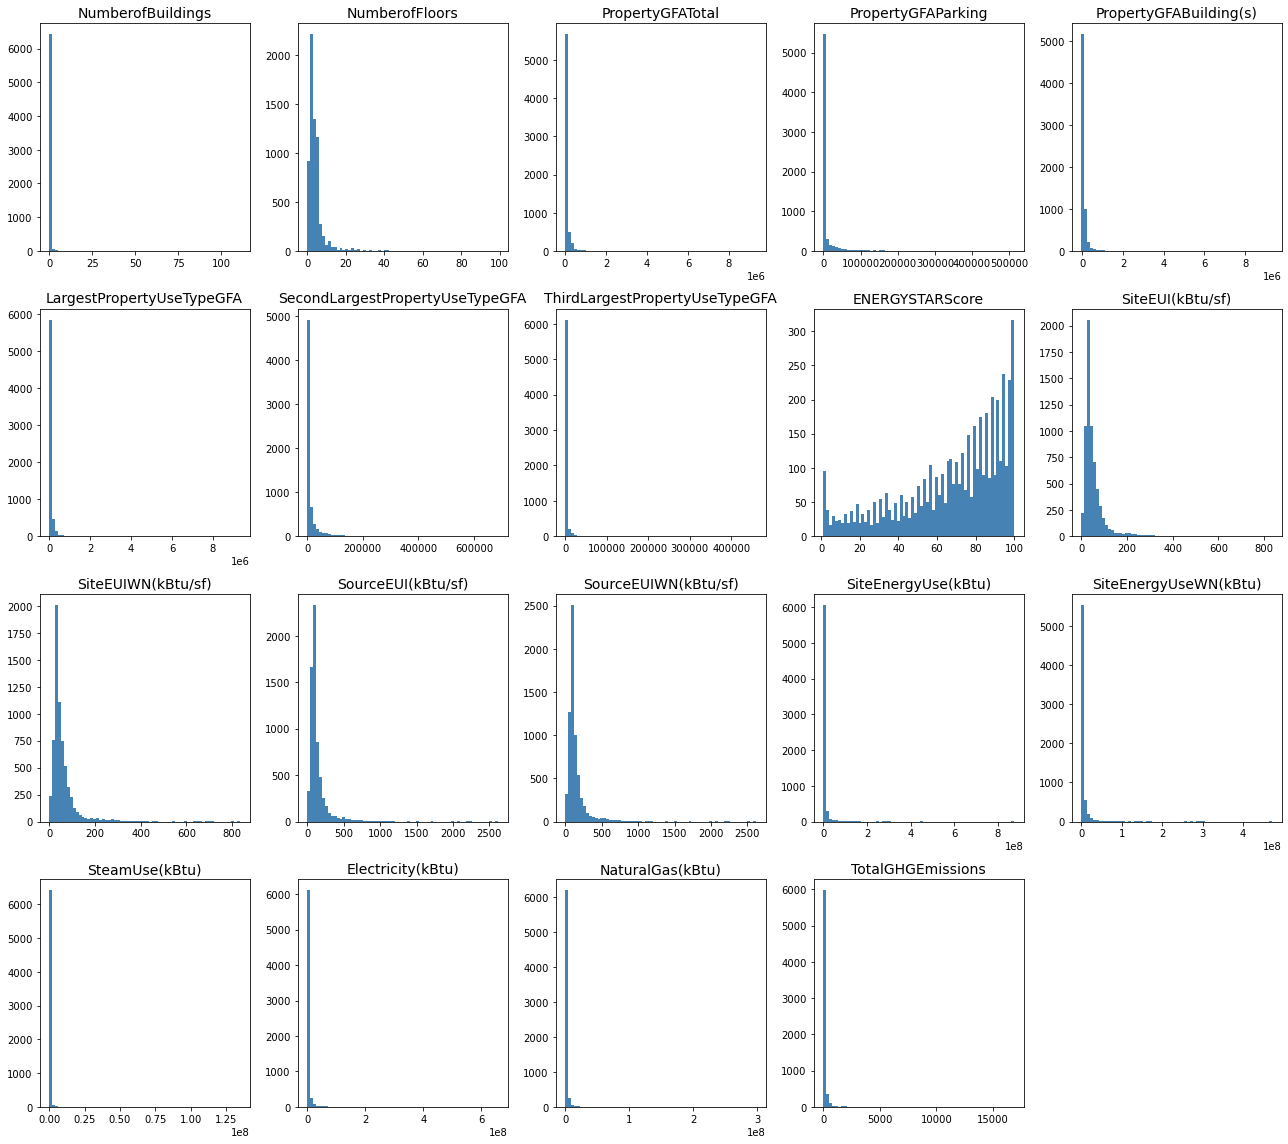

In [45]:
fig = plt.figure(figsize=(18, 16))
for feat_idx, feat in enumerate(quantitative_features):
    ax = fig.add_subplot(4,5, (feat_idx+1))
    h = ax.hist(raw_data[feat], bins=5*int(1+np.log2(raw_data.shape[0])), color = 'steelblue', density=False, edgecolor='none')
    ax.set_title(feat, fontsize=14)
    plt.tight_layout()

On remarque que les données sont très dispersées. On observe également des échelles de variation très différentes d'une variable à l'autre. On a par ailleurs des outliers, et des valeurs à 0 (NumberofBuildings, TotalGHGEmission, LargestPropertyUseTypeGFA etc.) qui sont probablement des valeurs aberrantes.

### II.2.2 outliers

Pour le traitement des outliers on va utiliser à profit la colonne "Outlier", effectuer des filtrages "à la main", et utiliser la relation qui existe entre les variables SiteEUI et SiteEnergyUse

R2 avant nettoyage: 0.90
R2 après nettoyage: 0.98


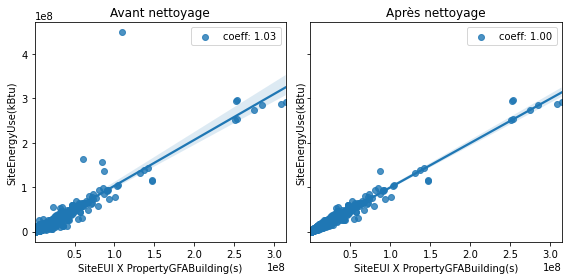

In [46]:
### 1. traitement par la colonne "outliers" ###

# On commence par regrouper les outliers dans la catégorie "Yes", et les valeurs NaN dans "No"
outlier_yn = raw_data["Outlier"].where(raw_data["Outlier"].notna(), "No")
raw_data["Outlier_yn"] = outlier_yn
raw_data["Outlier_yn"] = raw_data["Outlier_yn"].apply(lambda x: "Yes" if x!="No" else x)

# On ne garde que les non-outliers
raw_data = raw_data.loc[raw_data.Outlier_yn=="No"]

# On supprime les colonnes "Outlier" et "Outlier_yn" qui ne sont plus utiles
raw_data.drop(columns=["Outlier", "Outlier_yn"], inplace=True)

# On supprime également cette variables de la liste categorical
categorical_features = categorical_features.drop(["Outlier"])

### 2. Filtrage "à la main"###

# On corrige les valeurs négatives de PropertyGFABuilding(s)
m = raw_data["PropertyGFABuilding(s)"] <= 0
raw_data["PropertyGFABuilding(s)"].mask(m, -raw_data["PropertyGFABuilding(s)"], inplace=True)

# On retire les valeurs de TotalGHGEmissions, NumberofBuildings qui sont négatives ou nulles, et
# les valeurs de SiteEnergyUse(kBtu) qui sont nulles (nécessaire pour prendre le logarithme des variables
# cibles en vue des prédictions)
d = raw_data.query("TotalGHGEmissions<=0 or NumberofBuildings<=0 or `SiteEnergyUse(kBtu)`==0").index
raw_data.drop(index=d, inplace=True)

# Il y a un bâtiment de 99 étages dont les émissions sont quasi-nulles: on l'écarte, il s'agit certainement
# d'un outlier.
raw_data = raw_data[raw_data.NumberofFloors<80] 

# On corrige les valeurs négatives de PropertyGFABuilding(s)
m = raw_data["PropertyGFABuilding(s)"] <= 0
raw_data["PropertyGFABuilding(s)"].mask(m, -raw_data["PropertyGFABuilding(s)"], inplace=True)

# On retire les valeurs de TotalGHGEmissions, NumberofBuildings qui sont négatives ou nulles, et
# les valeurs de SiteEnergyUse(kBtu) qui sont nulles (nécessaire pour prendre le logarithme des variables
# cibles en vue des prédictions)
d = raw_data.query("TotalGHGEmissions<=0 or NumberofBuildings<=0 or \
                   NumberofFloors==0 or `SiteEnergyUse(kBtu)`==0").index
raw_data.drop(index=d, inplace=True)

# Il y a un bâtiment de 99 étages dont les émissions sont quasi-nulles: on l'écarte, il s'agit certainement
# d'un outlier.
raw_data = raw_data[raw_data.NumberofFloors<80] 

### 3. Filtrage par la relation linéaire entre SiteEUI et SiteEnergyUse ###

# On cherche à comparer le coefficient de proportionnalité entre SiteEnergyUse et SiteEUI d'une part, et à 
# comparer ce coefficient avec la valeur de PropertyGFABuilding(s)

# Création de la statistique du coefficient de proportionnalité entre SiteEUI et SiteEnergyUse
var = "PropertyGFABuilding(s)"
prop_coef = raw_data["SiteEnergyUse(kBtu)"]/raw_data["SiteEUI(kBtu/sf)"]
stat = prop_coef/raw_data[var]
stat = pd.DataFrame(stat)

# On cherche à écarter les 2% de valeurs extrêmes
perc = 2
low, high = perc/200, 1-perc/200
conf_low, conf_high = stat.quantile(low).values[0], stat.quantile(high).values[0]

# Récupération des index des outliers
outlier_index = raw_data.loc[
    (raw_data["SiteEnergyUse(kBtu)"]>conf_high*raw_data[var]*raw_data["SiteEUI(kBtu/sf)"])
                         | (raw_data["SiteEnergyUse(kBtu)"]<conf_low*raw_data["SiteEUI(kBtu/sf)"]*raw_data[var])].index

# On écarte les outliers du jeu de données
d = raw_data.copy()
d.drop(index=outlier_index, inplace=True)

## Comparaisons avant/après nettoyage et affichage des graphes associés. ##
# Quelques définitions
SiteEnergyUse = d[var]*d["SiteEUI(kBtu/sf)"]
SiteEnergyUse_raw = raw_data[var]*raw_data["SiteEUI(kBtu/sf)"]
X = SiteEnergyUse.to_numpy().reshape(-1, 1)
y = d["SiteEnergyUse(kBtu)"].to_numpy()
X_r = SiteEnergyUse_raw.to_numpy().reshape(-1, 1)
y_r = raw_data["SiteEnergyUse(kBtu)"].to_numpy()

# Régressions linéaires sur chaque jeu de données (avant et après nettoyage):
# On utilise l'api statsmodel pour calculer le r2 avec et sans les outliers
import statsmodels.api as sm
model = sm.OLS(y, X)
model_r = sm.OLS(y_r, X_r)
results, results_r = model.fit(), model_r.fit()
print("R2 avant nettoyage: {:.2f}".format(results_r.rsquared))
print("R2 après nettoyage: {:.2f}".format(results.rsquared))

# Affichage des relations avant (gauche) et après (droite) nettoyage
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharey=True)
sns.regplot(x=SiteEnergyUse_raw, y=raw_data["SiteEnergyUse(kBtu)"], 
            label='coeff: {:.2f}'.format(results_r.params[0]),
            ax=ax1)
ax1.legend()
sns.regplot(x=SiteEnergyUse, 
            y=d["SiteEnergyUse(kBtu)"], 
            label='coeff: {:.2f}'.format(results.params[0]), 
            ax=ax2)
ax2.legend()
for ax, ti in zip([ax1, ax2], ["Avant nettoyage", "Après nettoyage"]):
    ax.set_xlabel(f"SiteEUI X {var}")
    ax.set_title(ti)
plt.tight_layout()
plt.show()

# création d'un nouveau dataframe
data = d
data.to_csv("./data.csv", index_label=False)

### II.2.3 feature engineering

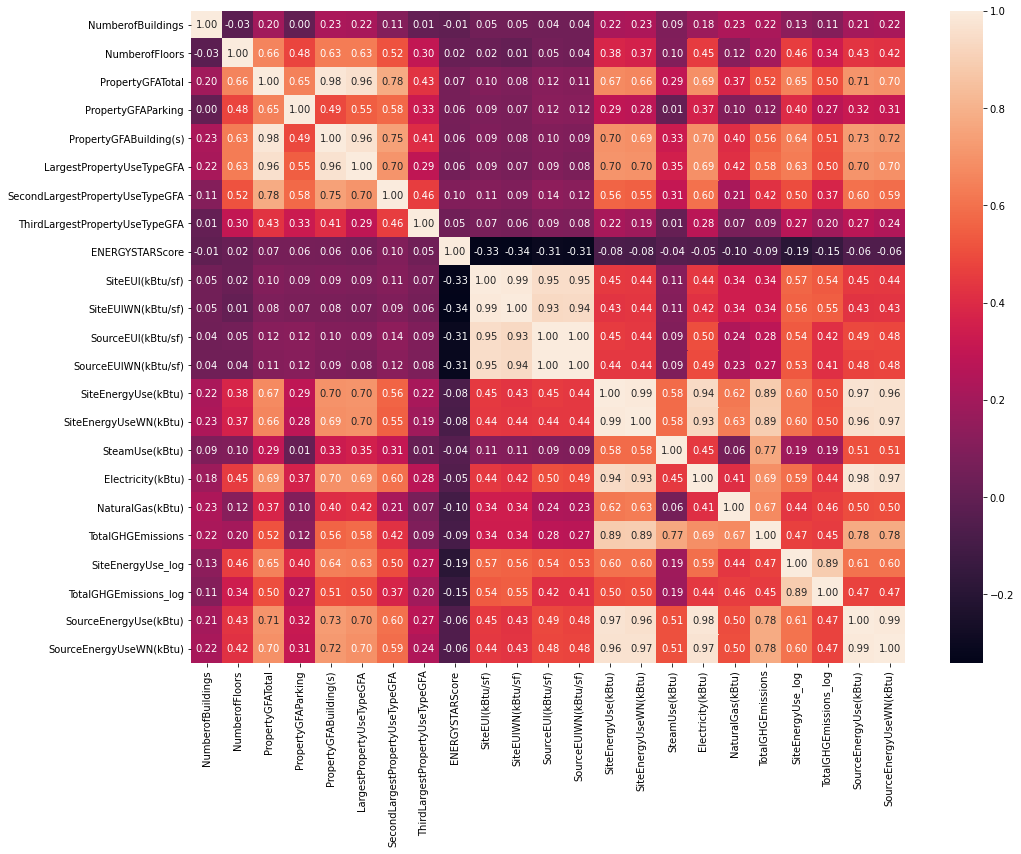

In [47]:
# chargement des données (dé-commenter si nécessaire)
#data = pd.read_csv("./data.csv")

# On prend le log des variables cibles, et on ajoute les nouvelles variables à la liste des variables 
# quantitatives.
data["SiteEnergyUse_log"] = data["SiteEnergyUse(kBtu)"].apply(np.log10)
data["TotalGHGEmissions_log"] = data["TotalGHGEmissions"].apply(np.log10)
targets = pd.Index(["SiteEnergyUse_log", "TotalGHGEmissions_log"])
quantitative_features = quantitative_features.append(pd.Index(["SiteEnergyUse_log", "TotalGHGEmissions_log"]))

# Création des variables SourceEnergyUseWN et SourceEnergyUse(kBtu), et ajout à la liste des variables 
# quantitatives.
data["SourceEnergyUseWN(kBtu)"] = data["SourceEUIWN(kBtu/sf)"]*data["PropertyGFABuilding(s)"]
data["SourceEnergyUse(kBtu)"] = data["SourceEUI(kBtu/sf)"]*data["PropertyGFABuilding(s)"]
quantitative_features = quantitative_features.append(pd.Index(["SourceEnergyUse(kBtu)", "SourceEnergyUseWN(kBtu)"]))

# Etude des corrélations
corr = data[quantitative_features].corr() # pearson
plt.figure(figsize=(16, 12))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()

* On a de fortes corrélations entre les variables "PropertyGFATotal", "PropertyGFABuilding(s)", "LargestPropertyUseTypeGFA": on va réaliser une ACP sur ces variables.

Par ailleurs,
* Ces variables sont elles-mêmes fortement corrélées à Electricity(kBtu)
* Electricity(kBtu) très fortement corrélée à SiteEnergyUSe
* Electricity, Steam, NaturalGas fortement corrélées à TotalGHGEmissions
* "L’objectif est de se passer des relevés de consommation annuels (attention à la fuite de données), mais rien n'interdit d’en déduire des variables plus simples (nature et proportions des sources d’énergie utilisées)."
$\rightarrow$On va donc créer ces nouvelles variables.

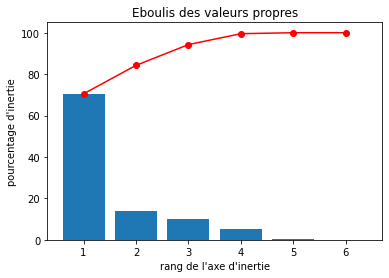

In [48]:
# Création des variables informant sur la nature et la proportion des sources d'énergie.
data["Electricity_ratio"] = data[["Electricity(kBtu)", "SiteEnergyUse(kBtu)"]].apply(lambda x: x[0]/x[1], axis=1)
data["NaturalGas_ratio"] = data[["NaturalGas(kBtu)", "SiteEnergyUse(kBtu)"]].apply(lambda x: x[0]/x[1], axis=1)
data["Steam_ratio"] = data[["SteamUse(kBtu)", "SiteEnergyUse(kBtu)"]].apply(lambda x: x[0]/x[1], axis=1)

# Ajout des nouvelles variables à la liste des variables quantitatives.
quantitative_features = quantitative_features.append(pd.Index(["Electricity_ratio", "NaturalGas_ratio", "Steam_ratio"]))

### ACP sur les variables liées à la surface au sol des bâtiments.###
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from functions import *

# choix du nombre de composantes à calculer
#n_comp = 4

# selection des colonnes à prendre en compte dans l'ACP
data_pca = data[["PropertyGFATotal", "PropertyGFAParking", "PropertyGFABuilding(s)",
                 "LargestPropertyUseTypeGFA","SecondLargestPropertyUseTypeGFA",
                 "ThirdLargestPropertyUseTypeGFA"
                ]]

## préparation des données pour l'ACP ##
X = data_pca.values
names = data_pca.index 
features = data_pca.columns

# Centrage et Réduction
std_scale = StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

## Calcul des composantes principales ##
pca = PCA()
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

On pourra se contenter des 4 premières variables lors de la prédiction.

On termine notre inspection des variables quantitatives avec NumberofFloors, NumberofBuildings, ENERGYSTARScore. Ces trois variables ont en commun d'être de type int64 et de posséder peu de modalités relativement à la taille de  la population.

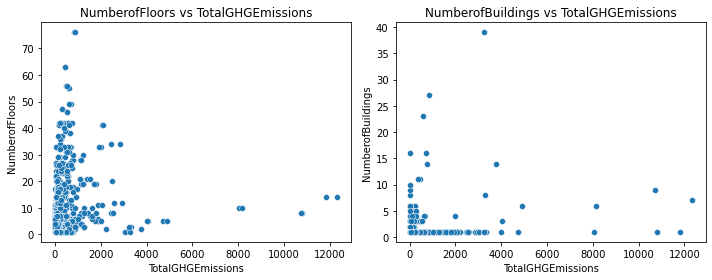

In [52]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))
for ax, var in zip([ax1, ax2], ["NumberofFloors", "NumberofBuildings"]):
    sns.scatterplot(data=data,
                y=var,
                x="TotalGHGEmissions",
                ax=ax)
    ax.set_title(f"{var} vs TotalGHGEmissions")
plt.tight_layout()
plt.show()

Regroupons les valeurs par modalités, afin d'afficher les valeurs moyennes de TotalGHGEmissions en fonction des modalités. Ceci afin de voir si il y existe une dépendance entre ces variables.

In [ ]:
# D'abord pour NumberofFloors

X = data["NumberofFloors"]
y = data["TotalGHGEmissions"]

ncounts = data.NumberofFloors.apply(lambda x: data[data.NumberofFloors==x].shape[0])
Wmodel = sm.WLS(y, X, weights=ncounts)
results = model.fit()

plt.scatter(X, y)
plt.plot(X.values, results.params[0]*X.values, '--r')
plt.ylim([0, 1000])
print("R2 après nettoyage: {:.2f}".format(results.rsquared))

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))
for ax, var in zip([ax1, ax2], ["NumberofFloors", "NumberofBuildings"]):
    sns.boxplot(data=data,
                y=var,
                x="TotalGHGEmissions",
                orient='h',
                ax=ax)
    ax.set_title(f"{var} vs TotalGHGEmissions")
plt.tight_layout()
plt.show()

## II.3 Variables catégorielles

### II.3.1 Nettoyage des variables catégorielles

On commence par afficher les variables catégorielles ainsi que le nombre de modalités pour chacune d'entre elles.

In [166]:
#categorical_features = categorical_features.drop(["ZipCode"])
pd.DataFrame(data={"nombre de modalités":data[categorical_features].nunique()})

,nombre de modalités
BuildingType,8
PrimaryPropertyType,30
Address,128
Neighborhood,18
LargestPropertyUseType,56
SecondLargestPropertyUseType,51
ThirdLargestPropertyUseType,44
DataYear,2
YearBuilt,113
CouncilDistrictCode,7


Création d'une fonction permettant l'affichage pour une variable catégorielle donnée des différentes modalités et du nombre de représentants pour chacune d'entre elles.

In [167]:
def valuecount_df(var):
    counts = data[var].value_counts()
    return pd.DataFrame({"nb_items": counts})

In [168]:
#categorical_features = ["BuildingType", "PrimaryPropertyType", "Neighborhood", "LargestPropertyUseType",
#                        "SecondLargestPropertyUseType", "ThirdLargestPropertyUseType", "Address", "YearBuilt",
#                        "NumberofBuildings", "NumberofFloors"]

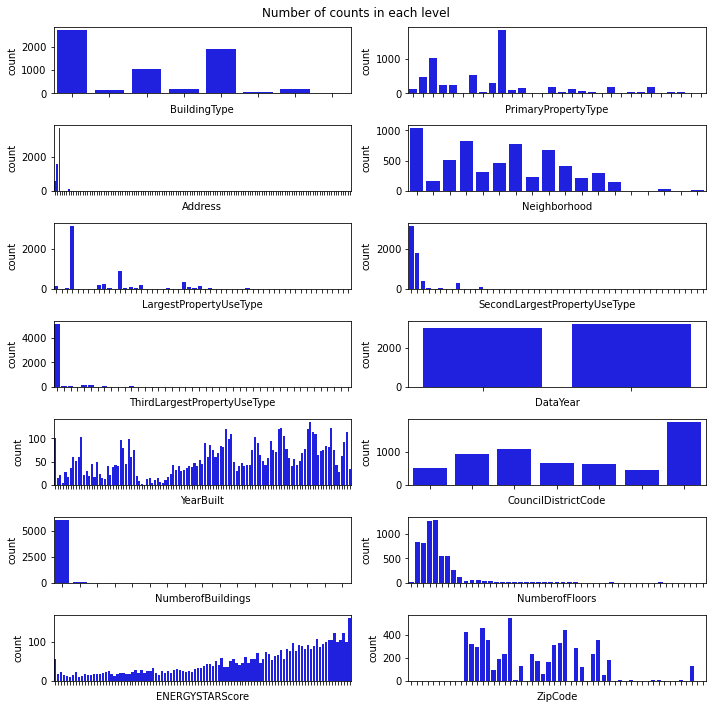

In [169]:
plt.figure(figsize=(10, 10))
plt.suptitle("Number of counts in each level")
for i, c in enumerate(categorical_features):
    ax = plt.subplot(7, 2, i+1)
    sns.countplot(data=data,
                  x=c,
                  color="b"
                  #orient="h",
                  #ax=axs[i]
                 )
    
    ax.set_xticklabels("")
    plt.tight_layout()
plt.show()    

On a $\approx$ 6200 éléments au total. Comme il y a pour chaque variable beaucoup de modalités ne comportant qu'un très faible nombre d'éléments, on va chercher à fusionner certaines modalités:
* Pour la variables YearBuilt, on va commencer par regrouper les années en décénnies.
* Pour les autres variables, on va fusionner toutes les catégories ayant moins de l'équivalent de 1% du jeu de données total. On considère que les modalités ayant trop peu d'éléments "bruitent" le modèle, plutôt que d'y apporter de l'information. On regroupera ces catégories dans la catégorie "Other".

Pour YearBuilt on commence par regrouper les années en décennies.

In [170]:
nb_decennies = 1+(data.YearBuilt.max()-data.YearBuilt.min())//10
bins = [1900+i*10 for i in range(nb_decennies)]
yb_grouped = np.digitize(data.YearBuilt, bins)
yb_grouped = pd.Series(data=yb_grouped, name="yb_grouped", dtype="int64")

data.YearBuilt = yb_grouped

**Etude de ENERGYSTARScore**

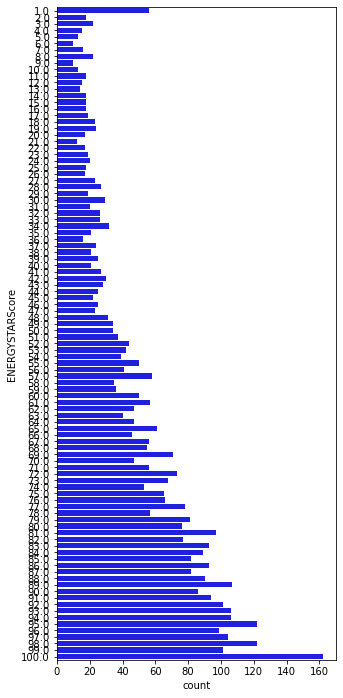

In [171]:
plt.figure(figsize=(5, 12)) 
sns.countplot(data=data,
                  y="ENERGYSTARScore", 
                  orient="h",
                  color="b"
                 )
plt.show()

<AxesSubplot:xlabel='ENERGYSTARScore', ylabel='SourceEnergyUseWN(kBtu)'>

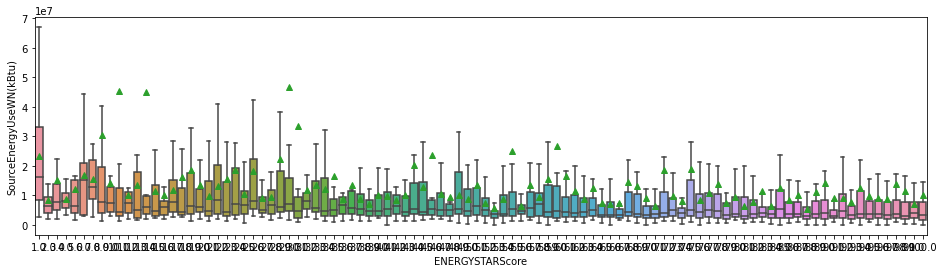

In [172]:
plt.figure(figsize=(16, 4))
sns.boxplot(x="ENERGYSTARScore", y="SourceEnergyUseWN(kBtu)", data=data, showfliers=False, showmeans=True, color=None)

Regroupement de ENERGYSTARScore en déciles?

In [173]:
nb_deciles = 1+(data.ENERGYSTARScore.max()-data.ENERGYSTARScore.min())//10
bins = [1+i*10 for i in range(int(nb_deciles))]
esc = np.digitize(data.ENERGYSTARScore, bins)
esc = pd.Series(data=esc, name="esc", dtype="int64")

data.ENERGYSTARScore = esc

<AxesSubplot:xlabel='ENERGYSTARScore', ylabel='SourceEnergyUseWN(kBtu)'>

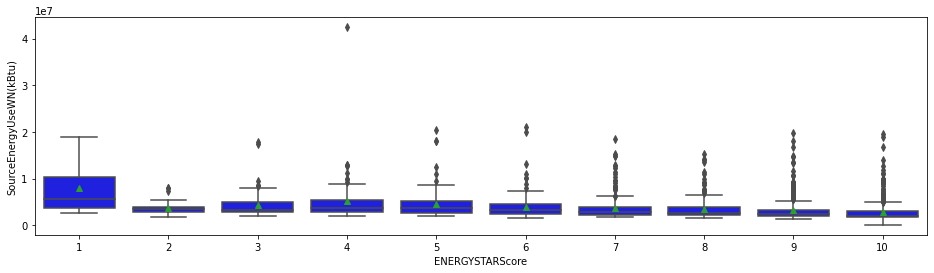

In [174]:
plt.figure(figsize=(16, 4))
sns.boxplot(x="ENERGYSTARScore", 
            y="SourceEnergyUseWN(kBtu)",
            data=data[data
                      .PrimaryPropertyType=="Low-Rise Multifamily"],
            showfliers=True,
            showmeans=True,
            color="b"
           )

In [177]:
def drop_class(features, prop_tokeep):
    d = data.copy()
    for f in features:
        vcounts = d[f].value_counts()
        nkeep = prop_tokeep*data.shape[0]
        d[f] = d[f].apply(lambda x: "Other" 
                                if vcounts[x] <= nkeep
                                else x)
    return d

# en fonction des résultats de prédiction des différents modèles on pourra modifier ce coefficient 
# pour écarter plus ou moins de modalités
prop_tokeep = [0.01, 0.02, 0.05, 0.1]

In [178]:
models = []
for p in prop_tokeep:
        models.append(drop_class(categorical_features, p))
        

Réaffichons les countplots de chaque variables catégorielle pour visualiser le résultat des fusions.

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  del sys.path[0]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  del sys.path[0]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  del sys.path[0]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  del sys.path[0]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all 

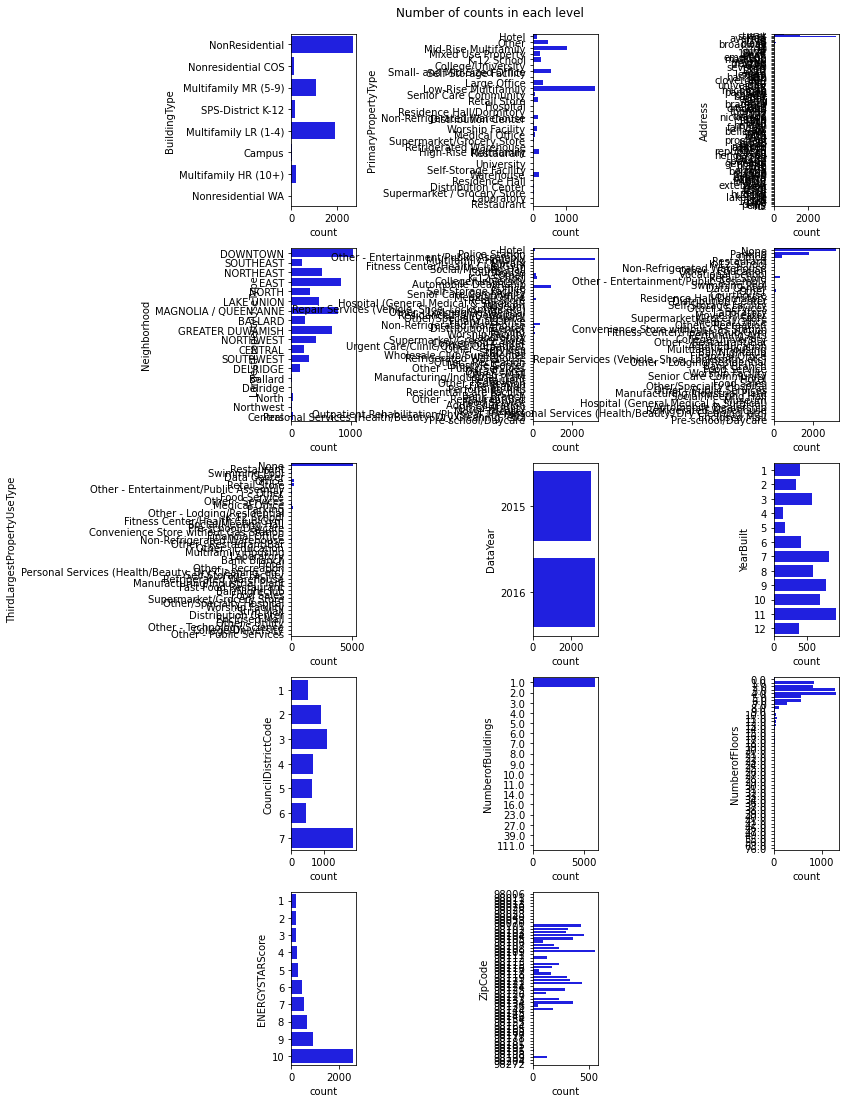

In [179]:
plt.figure(figsize=(10, 15))
plt.suptitle("Number of counts in each level", y=0.99)
for i, c in enumerate(categorical_features):
    ax = plt.subplot(5, 3, i+1)
    sns.countplot(data=models[1],
                  y=c, 
                  orient="h",
                  color="b"
                  #ax=axs[i]
                 )
    
    #ax.set_xticklabels("")
    plt.tight_layout()
plt.show()

In [180]:
models[0].to_csv("./modele1_1p.csv", index_label=False)
models[1].to_csv("./modele1_2p.csv", index_label=False)
models[2].to_csv("./modele1_5p.csv", index_label=False)
models[3].to_csv("./modele1_10p.csv", index_label=False)

# mise à jour du jeu de données
data = models[0] 

### II.3.2 Etude des corrélations

On inspecte les associations existantes entre les variables quantitatives, d'abord entre chacune d'elles et les variables cibles, puis entre elles.

Ecriture d'une fonction qui affiche les diagrammes en boîte de chaque modalité versus la variable cible (SiteEnergyUse ou TotalGHGEmissions). On utilise les variables "originales" et non leur log, car pour l'analyse des corrélations il est nécessaire que l'échelle de la variables cible soit linéaire, et non logarithmique [1](#http://vassarstats.net/textbook/)

In [181]:
def make_plot(var, target, xmin=None, xmax=None, ax=None):
    means = data.groupby(var)[target].mean().sort_values().index
    
    #fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6, 6), sharey=True)
    sns.boxplot(y=var, x=target, data=data, ax=ax, orient="h", showfliers=False, showmeans=True, order=means)
    #sns.countplot(data=data, y=var, orient="h", ax=ax2, order=means)
    try:
        ax1.set_xlim(xmin, xmax)
    except:
        pass
    #plt.show()

On écrit également une fonction permettant de réaliser une ANOVA. Cela permettra de déterminer les modalités qui peuvent être regroupées car statistiquement indiscernables. 

In [182]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

def make_anova(data, quant_var, cat_var, subcat=None):
    model = '{} ~ {}'.format(quant_var, cat_var)
    try:
        mod = ols(model, data=data[data[cat_var].isin(subcat)].dropna(subset=[quant_var, cat_var], how="any")).fit()           
    except:
        mod = ols(model, data=data.dropna(subset=[quant_var, cat_var], how="any")).fit()           
    aov_table = sm.stats.anova_lm(mod, typ=2)
    esq_sm = aov_table['sum_sq'][0]/(aov_table['sum_sq'][0]+aov_table['sum_sq'][1])

    #print("Résultats de l'ANOVA pour les variables {} et {}:".format(quant_var, cat_var))
    #print("F: {:.2f}, p: {:.3f}".format(aov_table.iloc[0]["F"], aov_table.iloc[0]["PR(>F)"]))
    #print("Eta-squared: {:.4f}".format(esq_sm))
    
    return aov_table, esq_sm

**Associations entre les cibles et les prédicteurs**

In [183]:
data.rename(columns={"SiteEnergyUse(kBtu)":"SiteEnergyUse", "SourceEnergyUseWN(kBtu)":"SourceEnergyUseWN"}, inplace=True) # La fonction ANOVA
target1 = "SiteEnergyUse"
target2 = "TotalGHGEmissions"

In [184]:
target = target1
anovas = {}
for var in categorical_features:
    aov_table, esq_sm = make_anova(data, target, var)
    anovas[var] = [aov_table.iloc[0]["F"], aov_table.iloc[0]["PR(>F)"], esq_sm]
    #print(make_anova(data, target, var))

print("Associations des variables catégorielles avec SiteEnergyUse")
df_corrSEU = pd.DataFrame.from_dict(data=anovas,
             columns=["F", "p-value", "eta-squared"],
                       orient="index"
            ).sort_values(by=["eta-squared"], ascending=False)
df_corrSEU

Associations des variables catégorielles avec SiteEnergyUse


,F,p-value,eta-squared
NumberofBuildings,3335.010403,0.000000e+00,0.350095
LargestPropertyUseType,41.234375,0.000000e+00,0.269830
PrimaryPropertyType,72.318638,0.000000e+00,0.253896
BuildingType,84.552584,6.640866e-118,0.087337
NumberofFloors,471.718858,7.286153e-101,0.070800
SecondLargestPropertyUseType,3.842388,3.575965e-18,0.030331
ThirdLargestPropertyUseType,4.099066,9.701609e-18,0.027866
Address,0.865203,8.588009e-01,0.017795
Neighborhood,5.970066,6.354533e-14,0.016170
ZipCode,18.029048,2.207433e-05,0.002904


In [185]:
target = target2
anovas = {}
for var in categorical_features:
    aov_table, esq_sm = make_anova(data, target, var)
    anovas[var] = [aov_table.iloc[0]["F"], aov_table.iloc[0]["PR(>F)"], esq_sm]
    #print(make_anova(data, target, var))

print("Associations des variables catégorielles avec {}".format(target2))
pd.DataFrame.from_dict(data=anovas,
             columns=["F", "p-value", "eta-squared"],
                       orient="index"
            ).sort_values(by=["eta-squared"], ascending=False)

Associations des variables catégorielles avec TotalGHGEmissions


,F,p-value,eta-squared
LargestPropertyUseType,63.484633,0.000000e+00,0.362632
PrimaryPropertyType,120.161530,0.000000e+00,0.361194
NumberofBuildings,830.186331,1.999900e-171,0.118240
BuildingType,66.374721,1.092643e-92,0.069872
SecondLargestPropertyUseType,3.803885,7.218093e-18,0.030036
NumberofFloors,170.281705,2.055364e-38,0.026768
Address,1.230287,4.181210e-02,0.025115
ThirdLargestPropertyUseType,3.499538,1.232235e-13,0.023888
Neighborhood,3.399668,2.605900e-06,0.009273
ENERGYSTARScore,25.836846,3.824345e-07,0.004156


Globalement moins d'association avec TotalGHGEmissions.

On confirme les résultats ci-dessus visuellement, grâce aux répartitions des différentes modalités pour chaque variable.

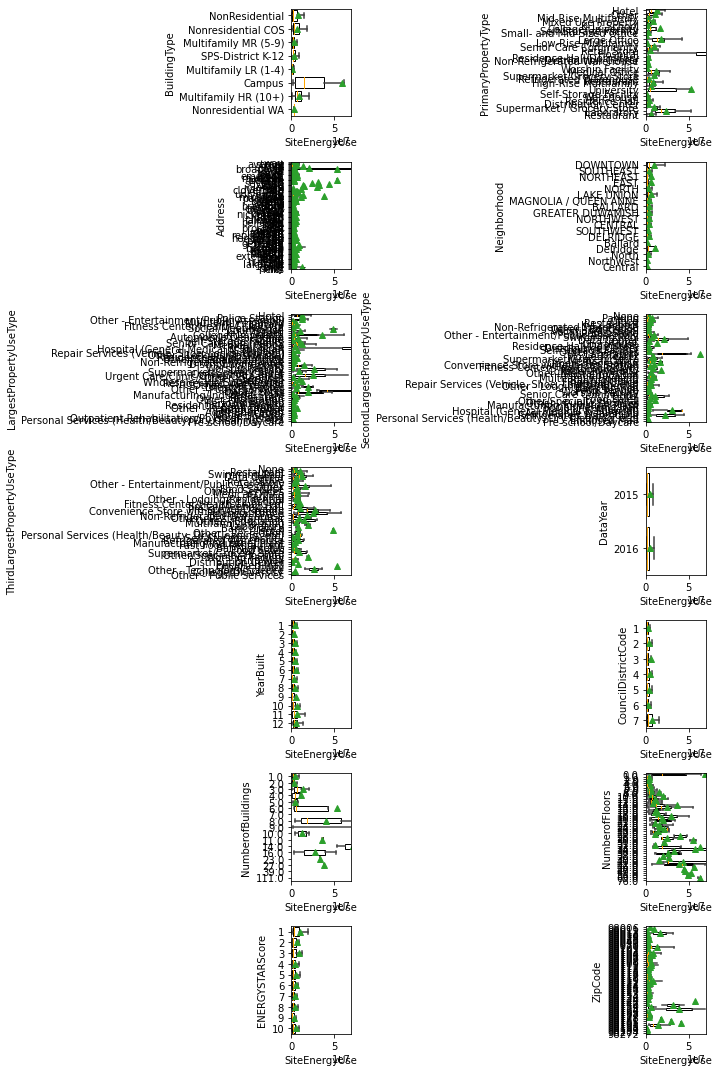

In [186]:
target = "SiteEnergyUse"
fig = plt.figure(figsize=(10, 15))
boxprops = dict(facecolor = "w", edgecolor='k', linewidth=1)
medianprops = dict(color='orange', linewidth=1)
for i, var in enumerate(categorical_features):
    ax = fig.add_subplot(7, 2, i+1)
    sns.boxplot(y=var, x=target, data=data, ax=ax, orient="h", showfliers=False, showmeans=True, 
                boxprops=boxprops, medianprops=medianprops)
    #ax.boxplot(data[[var, target]], vert=False, showfliers=False, showmeans=True)
    #make_plot(var, target, ax=ax)
    plt.tight_layout()
    ax.set_xlim([0, 7e7])
plt.show()


Création d'un nouveau modèle ne contenant que les variables catégorielles associées à plus de 5 % avec SiteEnergyUse.

In [187]:
least_correlated = df_corrSEU[df_corrSEU["eta-squared"]<0.05].index
least_correlated

Index(['SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType',
       'Address', 'Neighborhood', 'ZipCode', 'CouncilDistrictCode',
       'YearBuilt', 'ENERGYSTARScore', 'DataYear'],
      dtype='object')

In [188]:
data.drop(columns=least_correlated).to_csv("./modele2.csv", index_label=False)

On va maintenant inspecter les corrélations entre les 4 prédicteurs les plus associés avec SiteEnergyUse (association $\gt$ 5%). On définit la fonction contingence qui va permettre d'afficher les tables de contingence, et le résultat de tests du chi2 sur chaque paire.

In [189]:
from scipy.stats import chi2_contingency

def contingence(Var1, Var2, df):
    X=Var1
    Y=Var2
    cont = df[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")

    tx = cont.loc[:,["Total"]]
    ty = cont.loc[["Total"],:]
    n = len(df)
    indep = tx.dot(ty) / n

    c = cont.fillna(0) # On remplace les valeurs nulles par 0
    measure = (c-indep)**2/indep
    
    
    xi_n = measure.sum().sum()
    table = measure/xi_n
    totx = table.sum(axis=0)
    toty = table.sum(axis=1)
    plt.figure(figsize=(18, 6))
    sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1], fmt=".0f")
    chi2, pval, dof, chi2_table = chi2_contingency(c.iloc[:-1, :-1])
    
    #plt.figure(figsize=(18, 6))
    #sns.heatmap(chi2_table, annot=chi2_table, fmt=".0f")
    print("coefficient du chi2: {:.0f}".format(chi2))
    print("p-valeur: {}".format(pval))

**1. BuildingType**

coefficient du chi2: 22956
p-valeur: 0.0


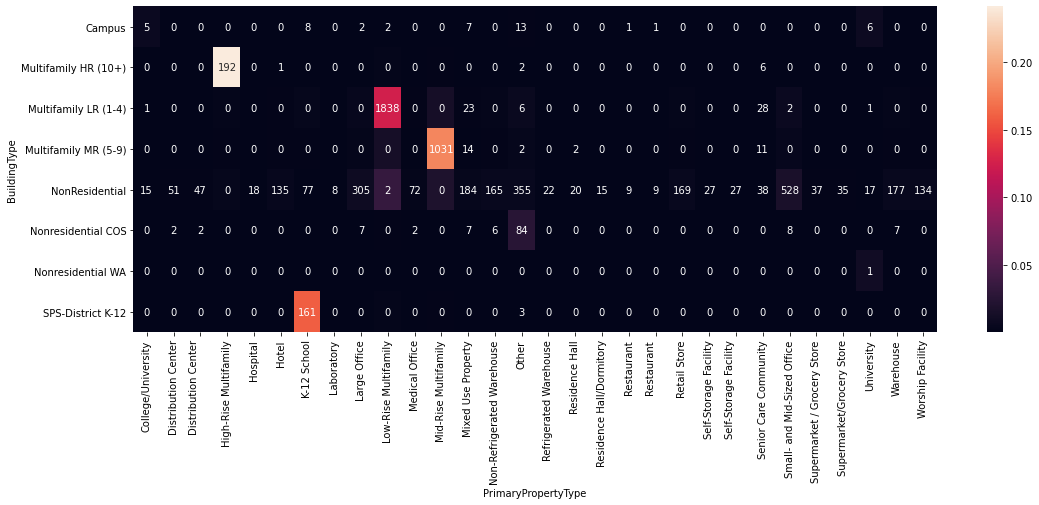

In [190]:
contingence("BuildingType", "PrimaryPropertyType", data)

coefficient du chi2: 11957
p-valeur: 0.0


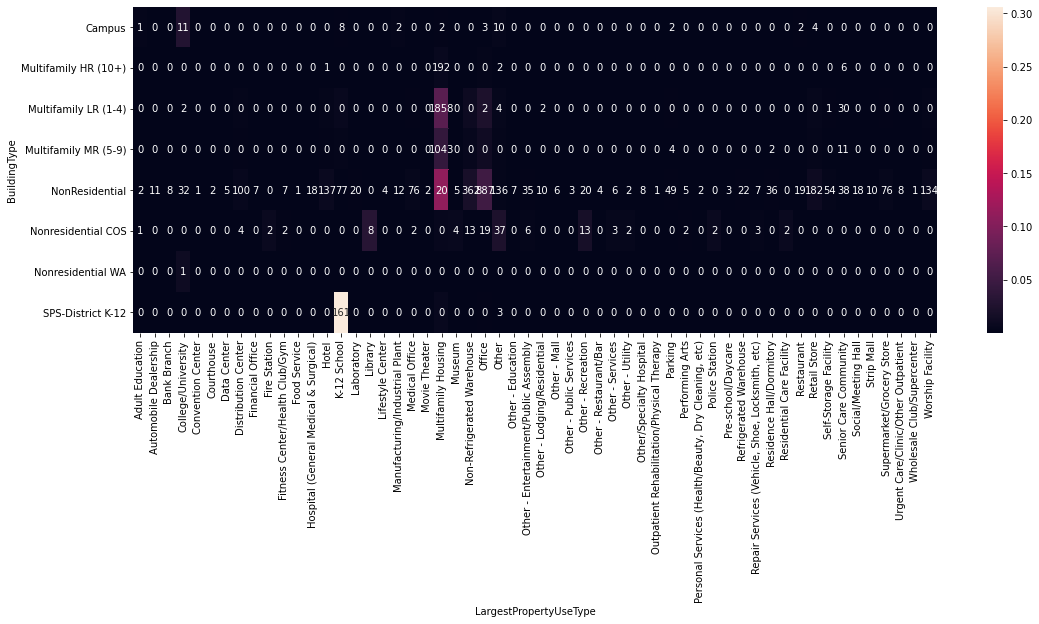

In [191]:
contingence("BuildingType", "LargestPropertyUseType", data)

coefficient du chi2: 10372
p-valeur: 0.0


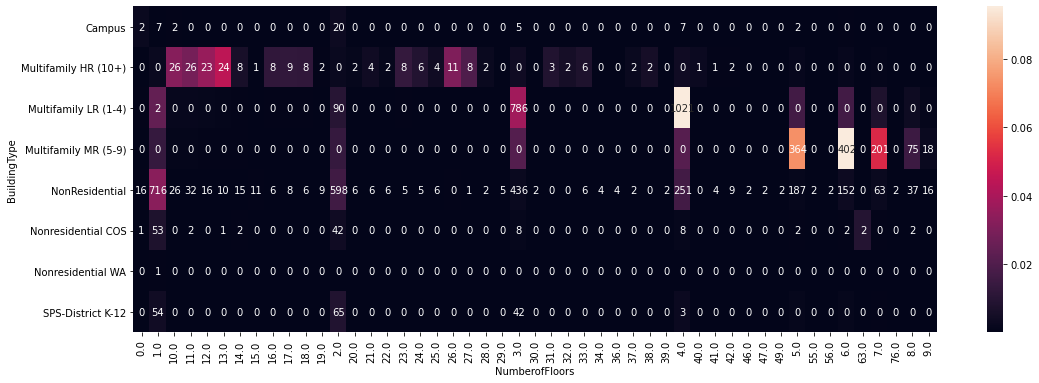

In [192]:
X="BuildingType"
Y="NumberofFloors"
data[Y] = data[Y].astype("str") # Pour éviter une erreur
contingence(X, Y, data)
data[Y] = data[Y].astype("object")

**2. PrimaryPropertyType**

coefficient du chi2: 104413
p-valeur: 0.0


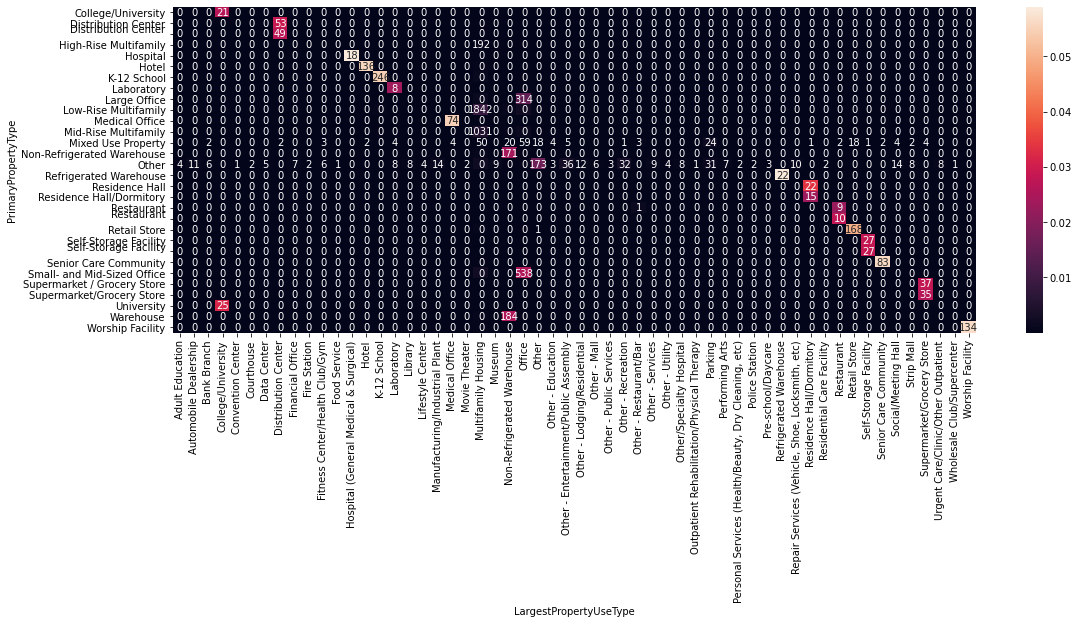

In [193]:
contingence("PrimaryPropertyType", "LargestPropertyUseType", data)

Forte redondance entre ces deux prédicteurs.

coefficient du chi2: 14420
p-valeur: 0.0


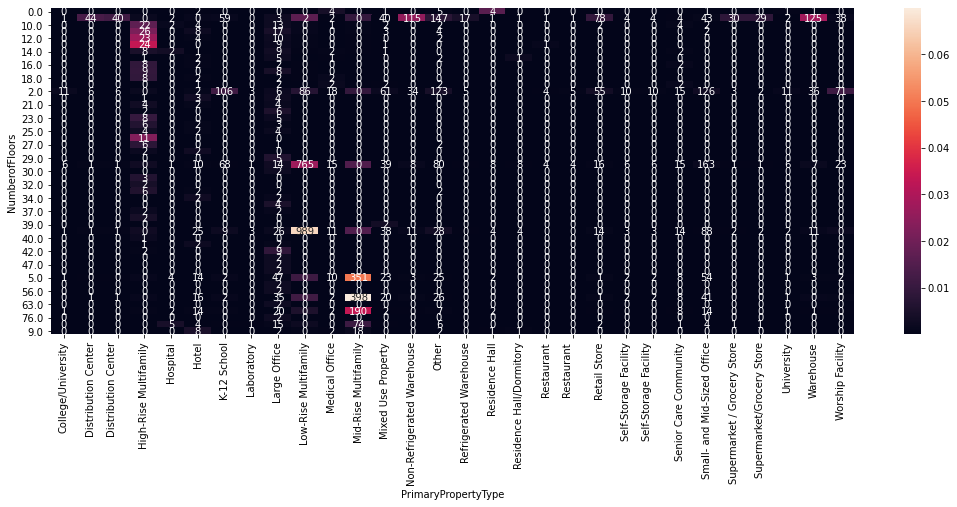

In [194]:
contingence("NumberofFloors", "PrimaryPropertyType", data)

**3. LargestPropertyUseType vs NumberofFloors**

coefficient du chi2: 7365
p-valeur: 0.0


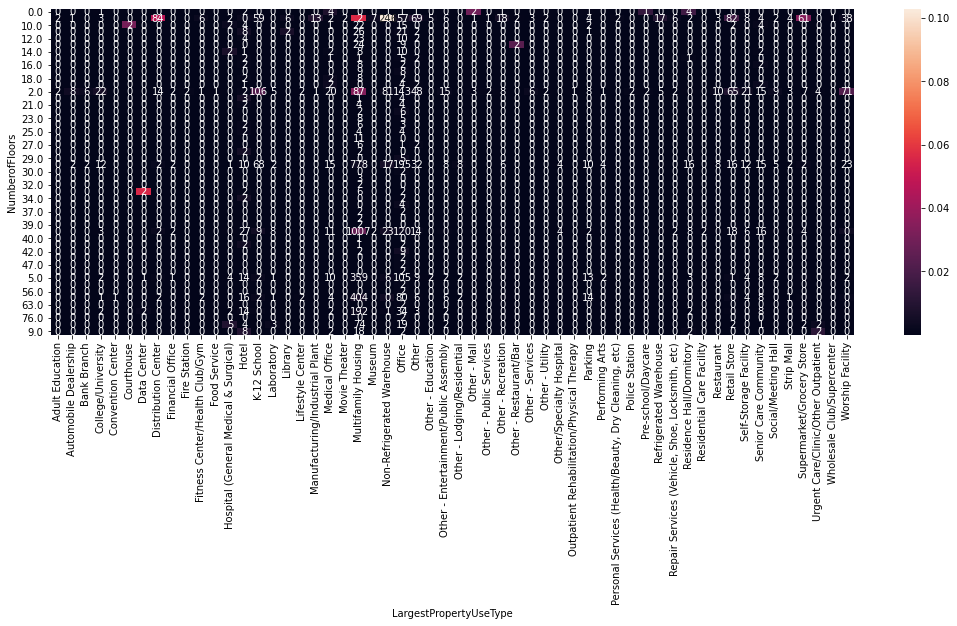

In [195]:
contingence("NumberofFloors", "LargestPropertyUseType", data)

coefficient du chi2: 2006
p-valeur: 2.6680255277095255e-266


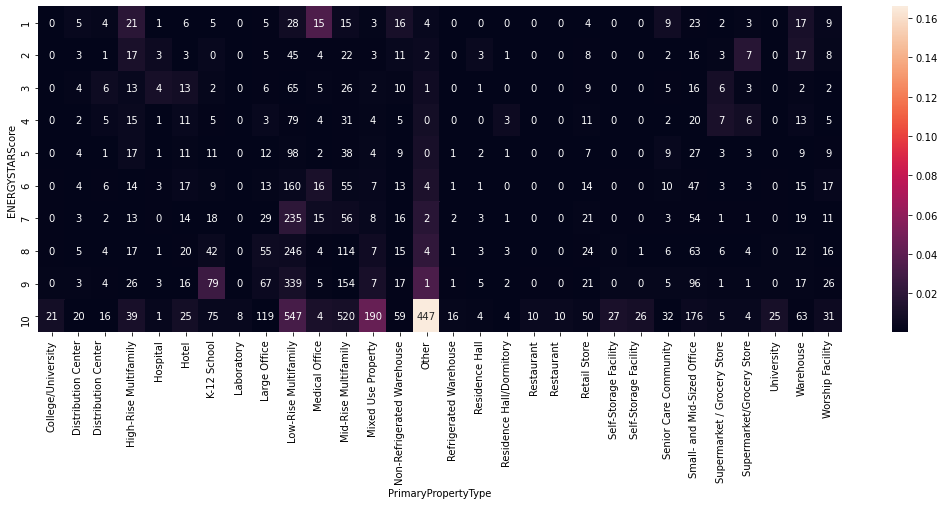

In [196]:
contingence("ENERGYSTARScore", "PrimaryPropertyType", data)

coefficient du chi2: 340
p-valeur: 2.854253650128509e-16


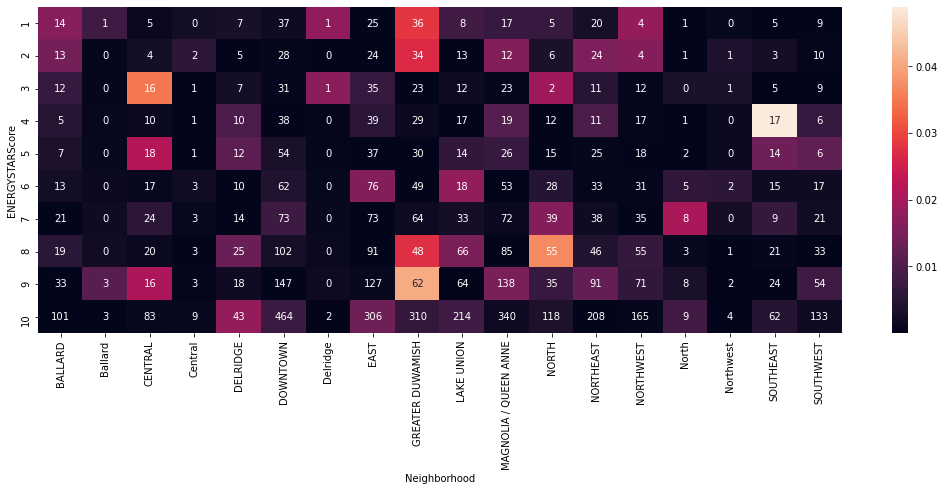

In [197]:
contingence("ENERGYSTARScore", "Neighborhood", data)

coefficient du chi2: 735
p-valeur: 2.7864333304060376e-13


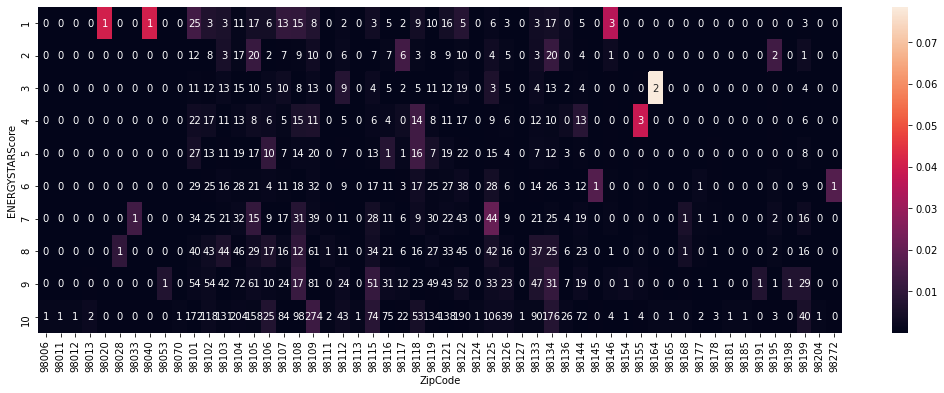

In [198]:
d = data.copy()
d.ZipCode = d.ZipCode.astype("str")
contingence("ENERGYSTARScore", "ZipCode", d)

coefficient du chi2: 366
p-valeur: 2.806825779941532e-32


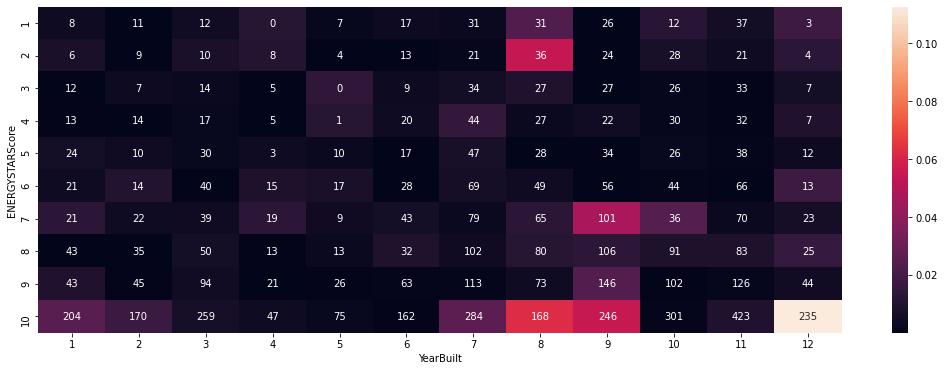

In [199]:
contingence("ENERGYSTARScore", "YearBuilt", data)